In [90]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt


# Synthetic Dataset Construction

In [126]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [127]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [128]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

# TODO: 
def gd(A, b_onehot, max_iter=1000, eta=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= eta * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist.append({
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            })

    hist_df = pd.DataFrame(hist)
    return hist_df

In [129]:
hist_gd_df = gd(A,b_onehot, eta=1)
hist_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,68.444660,0.033,0.271815,0.156250,0.031553
1,1,66.420041,0.038,0.269266,0.296875,0.056177
2,2,64.437363,0.041,0.266714,0.421875,0.084131
3,3,62.497315,0.045,0.264660,0.578125,0.114240
4,4,60.602199,0.052,0.262351,0.703125,0.130686
...,...,...,...,...,...,...
995,995,0.000765,1.000,0.000166,78.531250,14.667216
996,996,0.000764,1.000,0.000166,78.625000,14.678898
997,997,0.000763,1.000,0.000166,78.687500,14.695655
998,998,0.000763,1.000,0.000166,78.765625,14.713515


Sources:
https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372

# BCGD

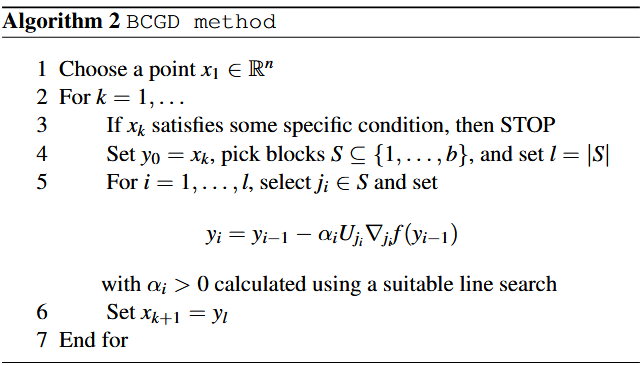

In [130]:
#TODO: calculate lipshitz constant.
L = 0.01
alpha = 1/L

In [134]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    
    X_out = X0
    X_out[:,i_k] += step.flatten()
    return X_out



# TODO: check optimality condition for early stopping.
def BCGD(coord_select, coord_step=coord_step, max_iter = 100, return_hist = True, step_size = alpha):
    # X_DEBUG = None
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        #X_cur = coord_step(X_cur, i_k, g_ik)
        coord_step(X_cur, i_k, g_ik, alpha=step_size)
        # if iter == 5:
        #     X_DEBUG = np.copy(X_cur)
        #     print('whoo')
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist.append(hist_iter)
    if return_hist:
        return pd.DataFrame(hist)#, X_DEBUG
    else:
        return
    
def grad_block(A, Y, X, i_k):
    # used for BCGD with random rule because you dont need full gradient
    Z = -A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    # Compute only the i_k-th column of the gradient
    grad_X_ik = 1/m * A.T @ (Y[:, i_k] - probs[:, i_k])
    return grad_X_ik

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    i_k = np.random.randint(num_classes) # select the coord (col)
    #g = grad(A, b_onehot, X)
    #g_ik = g[:,i_k].reshape((example_dim,1))
    g_ik = grad_block(A, b_onehot, X, i_k)
    return g_ik, i_k

In [135]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200)
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,68.925969,0.042,43,0.244953,0.125000,0.051122
1,1,66.915455,0.062,9,0.239723,0.281250,0.089122
2,2,65.257262,0.081,13,0.235827,0.375000,0.118134
3,3,63.208471,0.108,30,0.233920,0.578125,0.148779
4,4,61.540419,0.128,22,0.226220,0.765625,0.177193
...,...,...,...,...,...,...,...
195,195,0.000040,1.000,41,0.000042,15.468750,3.072675
196,196,0.000040,1.000,22,0.000041,15.562500,3.087675
197,197,0.000040,1.000,21,0.000041,15.656250,3.100676
198,198,0.000039,1.000,42,0.000040,15.671875,3.114679


In [ ]:
hist_BCGD_GS_ls_df, X_DEBUG = BCGD(gs_coord_select, coord_step=coord_step_linesearch, max_iter=200)
hist_BCGD_GS_ls_df

whoo


,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,7.143038e+01,0.039,20,2.580437e-01,0.609375,0.108032
1,1,6.914461e+01,0.069,14,2.507619e-01,1.375000,0.219006
2,2,6.734976e+01,0.090,28,2.420108e-01,2.031250,0.321704
3,3,6.548380e+01,0.109,41,2.339672e-01,2.812500,0.432940
4,4,6.334526e+01,0.131,49,2.333299e-01,3.578125,0.545568
...,...,...,...,...,...,...,...
195,195,9.322517e-07,1.000,33,9.639771e-07,609.500000,86.614602
196,196,9.279818e-07,1.000,32,9.583521e-07,614.515625,87.306857
197,197,9.236588e-07,1.000,8,9.555779e-07,619.906250,88.002918
198,198,9.193661e-07,1.000,49,9.462146e-07,624.953125,88.707473


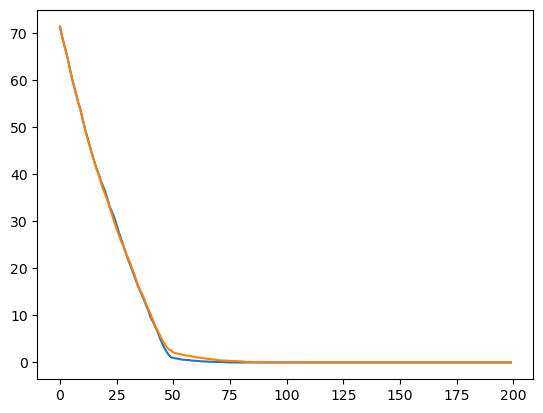

In [ ]:
plt.figure()
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['loss'])
plt.plot(hist_BCGD_GS_df['iter'], hist_BCGD_GS_df['loss'])

In [105]:
g_ik, i_k = gs_coord_select(X0)
X_cur = np.copy(X0)
def coord_step_linesearch(X_cur, i_k, g_ik):
    #hist_ls = []
    prev_loss = 1e10
    for i in range(100):
        step = - i * g_ik
        X_cur[:,i_k] += step.flatten()
        l = loss(A,b_onehot, X_cur)#
        # hist_ls.append({
        #     'iter': i,
        #     'loss': l
        # })
        if l > prev_loss:
            # by convexity, if the loss increases along our line search, stop searching.
            break
        prev_loss = l
# ls_df = pd.DataFrame(hist_ls)
# ls_df


NameError: name 'X_DEBUG' is not defined

In [99]:
ls_df['loss'].plot()

NameError: name 'ls_df' is not defined

In [136]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500)
hist_BCGD_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,69.164307,0.043,25,0.188452,0.187500,0.064831
1,1,67.671091,0.060,6,0.183691,0.328125,0.104832
2,2,66.068527,0.081,21,0.203843,0.484375,0.132830
3,3,64.320577,0.098,16,0.197488,0.640625,0.162369
4,4,62.970586,0.116,41,0.214978,0.843750,0.192369
...,...,...,...,...,...,...,...
495,495,0.000031,1.000,18,0.000045,39.125000,7.959054
496,496,0.000031,1.000,0,0.000031,39.203125,7.974575
497,497,0.000031,1.000,0,0.000028,39.328125,7.990575
498,498,0.000030,1.000,41,0.000044,39.437500,8.005575


In [137]:
def plot_hist(X_val, Y_val, dfs, legend_lables):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.

    fig = plt.figure()
    for i, hist_df in enumerate(dfs):
        plt.plot(hist_df[X_val], hist_df[Y_val], label=legend_lables[i])
    # plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    # plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    # plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel(X_val)
    plt.ylabel(Y_val)
    plt.show()

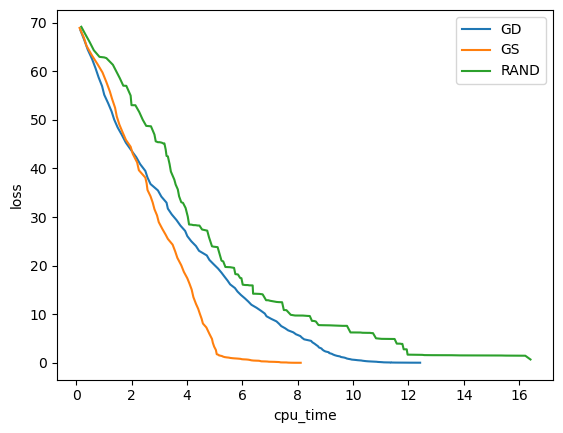

In [138]:
gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.
plot_hist('cpu_time', 'loss', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

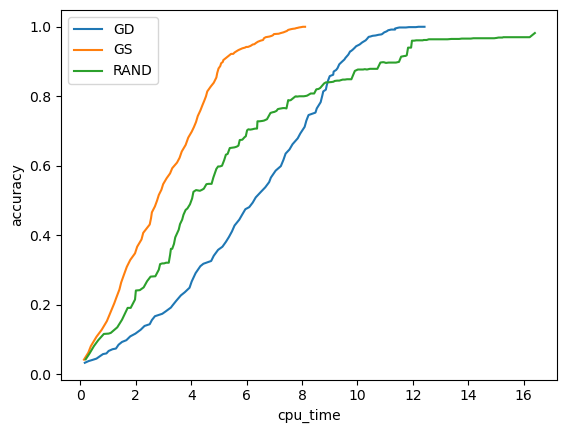

In [139]:
plot_hist('cpu_time', 'accuracy', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

In [140]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
iris = fetch_ucirepo(id=53) 
A_df = iris.data.features 
class_df = iris.data.targets 

In [141]:
b_names = class_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = class_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = A_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [150]:
gd_iris_df = gd(A, b_onehot, eta = 0.05)
gd_iris_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,7.035553,0.333333,7.047432,0.015625,0.012557
1,1,4.558378,0.333333,7.044138,0.031250,0.022314
2,2,2.234714,0.333333,6.987934,0.031250,0.023650
3,3,1.238078,0.566667,5.771684,0.031250,0.023650
4,4,0.930227,0.606667,2.821333,0.031250,0.024658
...,...,...,...,...,...,...
995,995,0.178251,0.960000,0.040241,1.359375,0.323812
996,996,0.178169,0.960000,0.040209,1.359375,0.323812
997,997,0.178086,0.960000,0.040178,1.359375,0.323812
998,998,0.178003,0.960000,0.040147,1.359375,0.323812


In [156]:
bcgd_gs_iris_df = BCGD(gs_coord_select, step_size=0.1, max_iter=1000)
bcgd_gs_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,6.217491,0.333333,0,5.747779,0.000000,0.001000
1,1,2.961818,0.333333,0,5.741439,0.000000,0.008064
2,2,1.154846,0.326667,0,5.428457,0.000000,0.009106
3,3,0.917601,0.253333,1,1.941350,0.031250,0.009106
4,4,0.878882,0.666667,2,0.819899,0.031250,0.010146
...,...,...,...,...,...,...,...
995,995,0.174593,0.953333,2,0.028601,1.796875,0.374990
996,996,0.174511,0.953333,2,0.028570,1.828125,0.374990
997,997,0.174430,0.953333,2,0.028539,1.828125,0.374990
998,998,0.174348,0.953333,0,0.028533,1.843750,0.375990


In [163]:
bcgd_rand_iris_df = BCGD(rand_coord_select, step_size=0.1, max_iter=500)
bcgd_rand_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,8.551884,0.333333,2,3.112061,0.000000,0.001749
1,1,7.584707,0.333333,2,3.111076,0.000000,0.002607
2,2,4.339738,0.333333,0,5.740180,0.000000,0.002607
3,3,3.642264,0.333333,1,2.641419,0.000000,0.007038
4,4,2.947723,0.333333,1,2.638836,0.000000,0.007038
...,...,...,...,...,...,...,...
495,495,0.294265,0.946667,0,0.044693,0.640625,0.147393
496,496,0.294069,0.946667,0,0.044370,0.640625,0.147393
497,497,0.293613,0.946667,2,0.067595,0.640625,0.147393
498,498,0.293538,0.946667,1,0.027815,0.640625,0.148756


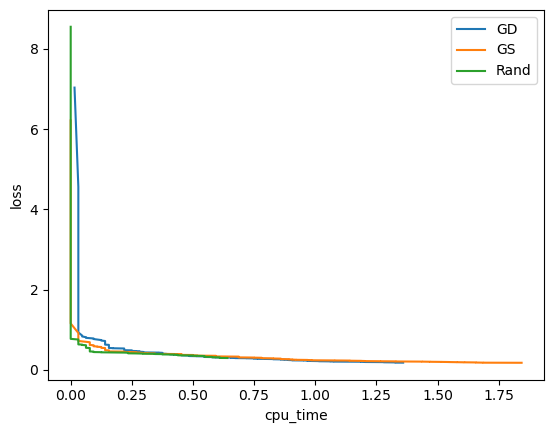

In [164]:
plot_hist('cpu_time', 'loss', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

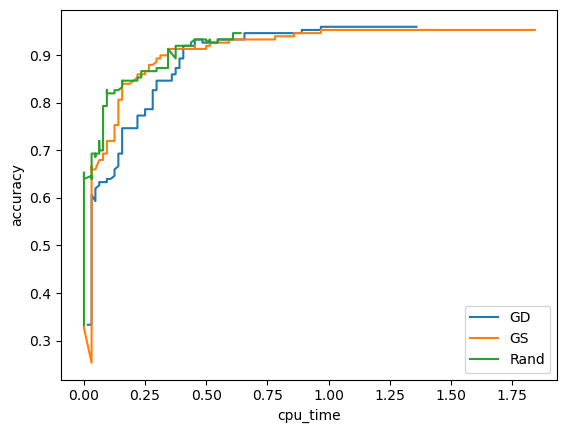

In [168]:
plot_hist('cpu_time', 'accuracy', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

In [174]:
from sklearn.preprocessing import StandardScaler
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
wine_feats_df = wine.data.features 
wine_target_df = wine.data.targets 

scaler = StandardScaler()
wine_feats_df = pd.DataFrame(scaler.fit_transform(wine_feats_df), columns=wine_feats_df.columns)

In [175]:
wine_feats_df

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


In [176]:
wine_target_df

,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [177]:

b_names = wine_target_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = wine_target_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = wine_feats_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [188]:
wine_gd_df = gd(A, b_onehot, eta=5, max_iter=100)
wine_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,0.196444,0.932584,1.007084,0.031250,0.003994
1,1,0.068951,0.977528,0.196301,0.031250,0.005203
2,2,0.048269,0.983146,0.061720,0.031250,0.007256
3,3,0.038160,0.983146,0.036605,0.046875,0.011707
4,4,0.032089,0.988764,0.028515,0.046875,0.012752
...,...,...,...,...,...,...
95,95,0.005329,1.000000,0.002165,0.359375,0.066142
96,96,0.005293,1.000000,0.002149,0.359375,0.067144
97,97,0.005258,1.000000,0.002133,0.375000,0.067144
98,98,0.005223,1.000000,0.002117,0.390625,0.068142


In [196]:
wine_bcgd_gs_df = BCGD(gs_coord_select, coord_step)#(A, b_onehot, eta=1, max_iter=100)
wine_bcgd_gs_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,22.109878,0.719101,1,0.820918,0.000000,0.001189
1,1,2.190292,0.898876,1,0.745920,0.000000,0.002195
2,2,0.508645,0.971910,0,0.229086,0.000000,0.002942
3,3,0.220714,0.971910,1,0.054003,0.000000,0.002942
4,4,0.102552,0.983146,1,0.049310,0.015625,0.003950
...,...,...,...,...,...,...,...
95,95,0.000226,1.000000,2,0.000152,0.281250,0.059201
96,96,0.000223,1.000000,0,0.000150,0.281250,0.060219
97,97,0.000221,1.000000,2,0.000148,0.281250,0.060219
98,98,0.000219,1.000000,1,0.000147,0.281250,0.060219


In [195]:
wine_bcgd_rand_df = BCGD(rand_coord_select, coord_step)#(A, b_onehot, eta=1, max_iter=100)
wine_bcgd_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,5.228573,0.679775,0,0.523110,0.031250,0.013151
1,1,1.534409,0.730337,0,0.239958,0.031250,0.014186
2,2,1.747190,0.893258,2,0.453231,0.031250,0.014186
3,3,1.687998,0.904494,0,0.074338,0.031250,0.015466
4,4,0.495838,0.955056,1,0.256163,0.031250,0.015466
...,...,...,...,...,...,...,...
95,95,0.000147,1.000000,2,0.000127,0.671875,0.234738
96,96,0.000145,1.000000,1,0.000150,0.671875,0.234738
97,97,0.000144,1.000000,0,0.000072,0.671875,0.234738
98,98,0.000142,1.000000,1,0.000146,0.671875,0.235739


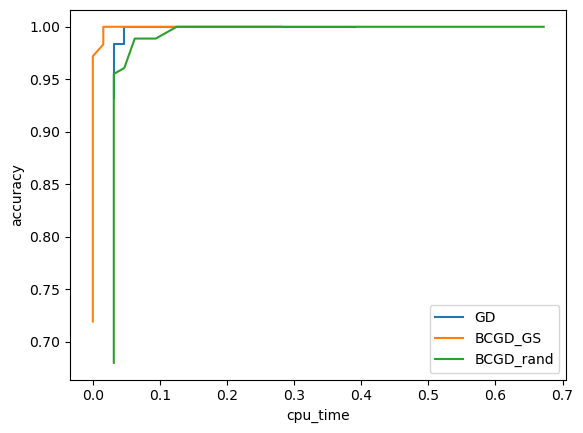

In [197]:
plot_hist('cpu_time', 'accuracy', [wine_gd_df, wine_bcgd_gs_df, wine_bcgd_rand_df], ['GD', 'BCGD_GS', 'BCGD_rand'])

In [192]:
loss(A, b_onehot, X0)

1.4156810380184817